In [1]:
import os 

In [ ]:
print(os.getcwd())

In [3]:
os.chdir(r'F:\Yahootsf')

<u><b>Data Wrangling and Exploration</b></u>

<br>The data has several potential columns for us to use for forecasting:</br>

<br><b><u>Open</u></b>: the opening value of the index on that day</br>
<br><b><u>High</u></b>: the highest value of the index on that day</br>
<br><b><u>Low</u></b>: the lowest value of the index on that day</br>
<br><b><u>Close</u></b>: the closing value of the index on that day</br>
<br><b><u>Volume</u></b>: the total volume of the index traded on that day</br>
<br><b><u>Adj Close</u></b>: the closing value of the index on that day adjusted for dividends</br>

Lets read the Dataset using Pandas to have an idea about our Dataset

In [4]:
import pandas as pd

In [5]:
df = pd.read_csv('yahoo_stock.csv',index_col =0)
df= df.sort_index()

Time series forecasting is about predicting how a target variable evolves over time by analyzing its past values. So for this model it is required that we change the Date column as our index sort it using <b>sort_index()</b> and remove the other columns apart from our target variable 'Adj Close'.

In [6]:
df.head(5)

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-11-23,2095.610107,2081.389893,2089.409912,2086.590088,3.587980e+09,2086.590088
2015-11-24,2094.120117,2070.290039,2084.419922,2089.139893,3.884930e+09,2089.139893
2015-11-25,2093.000000,2086.300049,2089.300049,2088.870117,2.852940e+09,2088.870117
2015-11-26,2093.000000,2086.300049,2089.300049,2088.870117,2.852940e+09,2088.870117
2015-11-27,2093.290039,2084.129883,2088.820068,2090.110107,1.466840e+09,2090.110107


In [7]:
df =df.drop(['Close','Open','High','Low','Volume'],axis =1)

In [ ]:
df.head() #sanity check

,Adj Close
Date,
2015-11-23,2086.590088
2015-11-24,2089.139893
2015-11-25,2088.870117
2015-11-26,2088.870117
2015-11-27,2090.110107


We have removed all the columns from the dataset except for our Target variable using the Drop method . Now we should explore this Feature for Cleaning & preprocessing , Scaling and Windowing. First lets check for any missing values.

In [9]:
df.isnull().sum()

Adj Close    0
dtype: int64

Fortunately, We dont have any missing values for our Adjusted Closing value feature . Lets visualize our Target Variable with respect to time to analyze the pattern. 

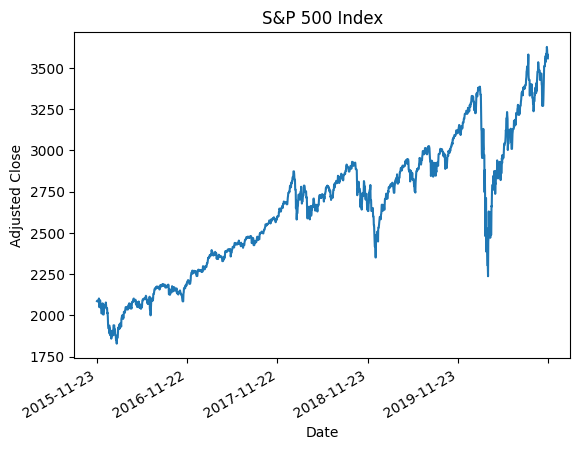

In [10]:
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates

plt.plot(df)

plt.title('S&P 500 Index')
plt.xlabel('Date')
plt.xticks(rotation = 45)
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gcf().autofmt_xdate()
plt.ylabel('Adjusted Close')
plt.show()


The plot is looking great! We can see that we have data from about five years to work with. There are no gaps, and there are some visible dips and spikes.
We can see that the Adjusted Closing feature which was already prepared for the purpose of Dividends shows us that , at every start of the year the index goes down (Some years a slight decrease and a drastic fall on the other years) and gradually increases before next year.<br> While this visualization gives us a perfect feeling to deploy an RNN model , We need to preprocess , scale and window it . Lets try Split our Data starting from the very earliest to the next 60% of the total length of Data to Training , the next 20% to Validation and the rest 20 to our Test set. Why we do this manually instead of using Train_test_split ? The answer is very simple: since we are doing a Time-series forecasting , We must assign the earliest historical data to the training set and reserve the later portions for validation set and test set .This ensures that the model is evaluated on truly unseen future data. </br>

<b><u>Data Pre-processing </u></b>

We need to do 2 things with our raw data inorder make it ready for an RNN . 
1) Split the Data - This can be done manually by us 60% - Training , 20%-Validation , the last 20% - test
2) Normalize the Data and ensure the values are between 0 and 1 using the scaler from Sklearn Library .

In [11]:
n = len(df)
train_end = int(0.6 * n)
val_end = int(0.8 * n)
train = df.iloc[:train_end]
val = df.iloc[train_end:val_end]
test = df.iloc[val_end:]

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

scaler.fit(train)

train = pd.DataFrame(scaler.transform(train),columns = ['Adj Close'], index = train.index)
val = pd.DataFrame(scaler.transform(val),columns = ['Adj Close'],index = val.index)
test = pd.DataFrame(scaler.transform(test),columns = ['Adj Close'],index = test.index)

Now that we have splitted and scaled our data its time for us to split this data between X and y . this can be done defining a helper function which takes a Dataset and a window_size as an argument and append the window to the X and the target to the y, returning us the arrays of X and y  . The function can be written as follows:

In [12]:
import numpy as np


def create_dataset(orig_dataset ,window_size = 1):
    data_x , data_y = [],[]
    for i in range(len(orig_dataset)- window_size -1):
        window = orig_dataset.iloc[i :(i+window_size),0]
        target = orig_dataset.iloc[i+window_size,0]
        data_x.append(window)
        data_y.append(target)
    return np.array(data_x),np.array(data_y)


Now that we have defined the helper function , Lets make use of it to split between X_train , y_train from train , X_val , y_val from Val and X_test, y_test from the test set . Also it is important for us to reshape them into 3d arrays to make it suitable for an RNN model or a  CNN model or both combined .

In [13]:
import numpy as np 
window_size = 10 

X_train,y_train = create_dataset(train,window_size )
X_val,y_val = create_dataset(val , window_size)
X_test,y_test = create_dataset(test, window_size)

X_train = np.reshape(X_train ,( X_train.shape[0],1,X_train.shape[1]))
X_val = np.reshape(X_val, (X_val.shape[0],1,X_val.shape[1]))
X_test = np.reshape(X_test,(X_test.shape[0],1,X_test.shape[1]))


Lets build a normal model to ensure everything's perfect So that we can have our shift our mindset to Optimizing. 

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers # type: ignore

model = tf.keras.Sequential()
model.add(layers.LSTM(10 , input_shape =(1,window_size)))
model.add(layers.Dense(5 , activation = 'relu'))
model.add(layers.Dense(1))
model.compile(optimizer = 'adam',loss = 'mean_squared_error')
model.summary()

In [15]:
model.fit(X_train,y_train, epochs = 10)


Epoch 1/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3748
Epoch 2/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3003
Epoch 3/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2488
Epoch 4/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1675
Epoch 5/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0805
Epoch 6/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0304
Epoch 7/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0186
Epoch 8/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0161
Epoch 9/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0139
Epoch 10/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0118


In [16]:
from sklearn.metrics import r2_score
y_pred = model.predict(X_val)
print(r2_score(y_val,y_pred))

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
-0.16089402066476755


We can see after fitting the a simpleRNN model that doesnt memorize like the LongShortTermMmemory (LSTM) or Gated recurrent units(GRU) , we have a negative r2_score which says we have a lot of optimization to do with our model. Lets try building a LSTM model and try adding a CNN ie ., a 1D convolutional layer, and also adding or removing layers , increasing or decreasing the number of nodes , using different optimizers and loss functions to achieve a better performance . 

In [ ]:
window_size = 10
model = tf.keras.Sequential()
model.add(layers.Conv1D(filters = 128,kernel_size = 1 ,input_shape = (1,window_size)))
model.add(layers.MaxPooling1D(1))
model.add(layers.LSTM(64, activation = 'relu'))
model.add(layers.Dense(32 , activation = 'relu'))
model.add(layers.Dense(1))
model.compile(optimizer = 'adam',loss = 'mean_squared_error')
model.summary()

In [23]:
model.fit(X_train,y_train,epochs = 40)

Epoch 1/40
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0407
Epoch 2/40
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0016
Epoch 3/40
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.9918e-04
Epoch 4/40
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.1372e-04
Epoch 5/40
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.5497e-04
Epoch 6/40
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.1438e-04
Epoch 7/40
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.9907e-04
Epoch 8/40
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.8923e-04
Epoch 9/40
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.2767e-04
Epoch 10/40
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.4269e-04
Epoch 11/40
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.8262e-04
Epoch 12/40
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.3927e-04
Epoch 13/40
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.2201e-04
Epoch 14/40
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.8525e-04
Epoch 15/40
34/34 ━━━━━━━━━━━━━━━━━━━

In [24]:
train_pred = model.predict(X_train)
val_pred = model.predict(X_val)
test_pred = model.predict(X_test)

print(r2_score(train_pred,y_train))
print(r2_score(val_pred,y_val))
print(r2_score(test_pred,y_test))

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
0.9959789601187466
0.9749589863008734
0.9614490323959186


Just like we expected , our model built with LSTM with Conv1D layers , gaves us excellent results of r2_scores with 99% on the training set , 97% on the validation set and a whooping 96% on the test set .Lets Visualize our performance but before that, lets unscale and unwindow the preprocessing we did .Thankfully , we have <b>inverse_transform()</b> , just like fit and transform from the scalers in the Sklearn library to do this . 

In [25]:
train_pred = scaler.inverse_transform(train_pred)
val_pred = scaler.inverse_transform(val_pred)
test_pred = scaler.inverse_transform(test_pred)

plot_train_pred = np.empty((len(df),1))
plot_train_pred[:] = np.nan
plot_train_pred[window_size:len(train_pred) + window_size, :] = train_pred

plot_val_pred = np.empty((len(df),1))
plot_val_pred[:] = np.nan
plot_val_pred[len(train_pred) + (window_size*2) + 1 :len(train_pred) + len(val_pred) + (window_size*2) + 1,:] = val_pred 

plot_test_pred = np.empty((len(df),1))
plot_test_pred[:] = np.nan
plot_test_pred[len(train_pred) + len(val_pred) + (window_size * 3) + 2:len(df) - 1,:] = test_pred


Finally , Lets plot the unscaled and unwindowed data on top of the original data . 

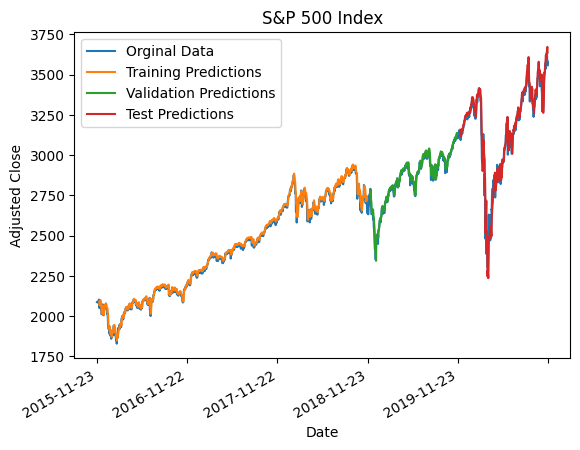

In [26]:
plt.plot(df , label = 'Orginal Data')


plt.plot(plot_train_pred , label = 'Training Predictions')
plt.plot(plot_val_pred,label = 'Validation Predictions')
plt.plot(plot_test_pred, label = 'Test Predictions')

plt.title('S&P 500 Index')
plt.xlabel('Date')
plt.xticks(rotation = 45)
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gcf().autofmt_xdate()
plt.ylabel('Adjusted Close')
plt.legend()
plt.show()

The visualization aligns well with the insights suggested by the R-squared score. However, the true evaluation of the model lies in forecasting future values and testing those predictions, potentially through simulated trades (“paper trading”). It is important to emphasize that this project is intended solely for Learning purposes. Financial markets are inherently complex and unpredictable; if accurate forecasting were straightforward, it would already be universally adopted. Therefore, the work presented here should be regarded as an exploration rather than investment advice.